In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
#from torch.autograd import Variable
#import cv2
import numpy as np
#import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = './lfw/lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
"""
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


torch.Size([250, 250, 3])


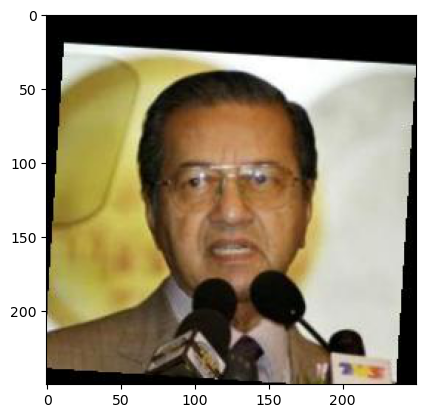

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [6]:
sample = next(iter(dataloader))

# Print the size of the complete batch
print("Tensor size:", sample[0].size())

#PRint the size of an individual image
print("Image size:", sample[0][0].size())

Tensor size: torch.Size([32, 3, 250, 250])
Image size: torch.Size([3, 250, 250])


32 - batch size i.e the number of images in a batch

3 - number of channels in the images
250 - the image height
250 - the image width

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [69]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()
        
        # The loss doesn't decrease for the below combination of layers
        # Encoder output size is 32x5x5 with 102499 parameters
        # The model fails to learn a majority of the image
        """
        self.encoding_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)
        )
        self.decoding_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 64, 2, stride=3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 128, 2, stride=4, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 3, stride=5, padding=4),
            nn.Sigmoid()
        )        
        """
        
        # Encoder output size is 64x15x15 for with 489603 parameters
        # The reconstructed image is blurry even after training for over 20 epochs        
        """
        self.encoding_layers = nn.Sequential(
            nn.Conv2d(3, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self.decoding_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, stride=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 128, 3, stride=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 2, stride=2, padding=2),
            nn.Sigmoid()
        )
        """
        
        # The encoded data is of size 32x30x30 with 262243 parameters
        # Training took over an hour for 10 epochs.
        """
        self.encoding_layers = nn.Sequential(
            nn.Conv2d(3, 128, 3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)
        )
        self.decoding_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 64, 4, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 128, 4, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 2, stride=2, padding=1),
            nn.Sigmoid()
        )
        """
        
        # The below combination of layers produces very good output.
        # But the intensity of the colors are a bit off.
        # After experimentation, it was found that the reason behind it was the 'Batch Normalization' layers
        """
        self.encoding_layers = nn.Sequential(
            nn.Conv2d(3, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 128, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Conv2d(128, 64, 2, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.decoding_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 2, stride=2, padding=2),
            nn.Sigmoid()
        )
        """
        
        # Final Model - Same as above, but without any batch normalization
        self.encoding_layers = nn.Sequential(
            nn.Conv2d(3, 256, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 128, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Conv2d(128, 64, 2, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.decoding_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 2, stride=2, padding=2),
            nn.Sigmoid()
        )  
        
    def encoder(self, x):
        return self.encoding_layers(x)

    def decoder(self, x):
        return self.decoding_layers(x)

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [70]:
# Create and move the model to GPU
model = AE().to(device)

In [71]:
# Move the image to GPU as well
image = sample[0][0].to(device)

# Unsqueeze the 3D tensor to 4D one
encoded_output = model.encoder(image.unsqueeze(0))
decoded_output = model.decoder(encoded_output)
print("Shape of Encoder Output:", encoded_output.shape)
print("Shape of Decoder Output:", decoded_output.shape)

Shape of Encoder Output: torch.Size([1, 64, 32, 32])
Shape of Decoder Output: torch.Size([1, 3, 250, 250])


Since the output of the decoder is the same size of an image, we can be sure that the forward path is working properly.

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [72]:
# The code iterates through all the parameters of the model, counting the number of elements in each parameter tensor,
# and then sums up these counts to determine the total number of parameters in the model.
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

print("Total number of parameters:", sum(p.numel() for p in model.parameters()))

Total number of parameters: 476035


In [73]:
import torch.optim as optim
optim = optim.Adam(model.parameters(), lr=0.001)

In [74]:
loss_function = nn.MSELoss()

The goal is to minimize the difference at the pixel level.
MSE loss directly penalizes the differences in pixel values between the original and reconstructed images since it measures the average squared difference between
the original input and the reconstructed output. Minimizing this loss encourages the model to generate outputs that closely resemble the input.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [75]:
# Total number of epochs the model will be trained for
num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0.0
    
    # For each of the batch in the dataloader
    for data in dataloader:
        # Split the data into images and targets
        images, _ = data
        # Move all the images to the GPU
        images = images.to(device)
        
        # Forward Pass - Perform Encoding + Decoding and calculating loss
        output = model(images)
        loss = loss_function(output, images)
        
        # Backward Pass - Reset the gradients, compute new gradients and update it
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # Accumulate the loss for all the batches in the epoch 
        total_loss += loss.item()
    print('Epoch [{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs, total_loss))

Epoch [1/20], Loss:2.7456
Epoch [2/20], Loss:0.4387
Epoch [3/20], Loss:0.3272
Epoch [4/20], Loss:0.2445
Epoch [5/20], Loss:0.2129
Epoch [6/20], Loss:0.1899
Epoch [7/20], Loss:0.1627
Epoch [8/20], Loss:0.1545
Epoch [9/20], Loss:0.1414
Epoch [10/20], Loss:0.1376
Epoch [11/20], Loss:0.1247
Epoch [12/20], Loss:0.1103
Epoch [13/20], Loss:0.1093
Epoch [14/20], Loss:0.0999
Epoch [15/20], Loss:0.0974
Epoch [16/20], Loss:0.0917
Epoch [17/20], Loss:0.0897
Epoch [18/20], Loss:0.0876
Epoch [19/20], Loss:0.0802
Epoch [20/20], Loss:0.0748


The loss did not decrease much for one of the models. The reason, the encoder output was 32x5x5, and that there was too much loss in information and
the decoder was unable to reconstruct the image.
Increasing the size of the encoder output caused the loss to decrease as the model was able to learn better.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

(-0.5, 249.5, 249.5, -0.5)

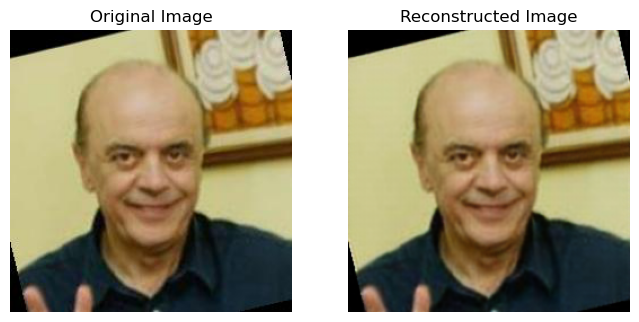

In [76]:
# Pick a random image
original = sample[0][4]

# Move the image to GPU
original = original.unsqueeze(0).to(device)

# Perform the forward pass
reconstruction = model(original)

# Move the original and reconstructed image back to CPU
original = original.squeeze(0).cpu().detach().numpy()
reconstruction = reconstruction.squeeze(0).cpu().detach().numpy()

# Display both the images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(np.transpose(original, (1, 2, 0)))
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(np.transpose(reconstruction, (1, 2, 0)))
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

(-0.5, 249.5, 249.5, -0.5)

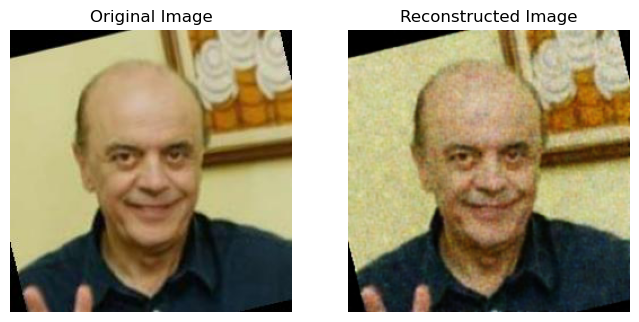

In [77]:
# Get the output of the encoder
encoded_output = model.encoder(sample[0][4].to(device).unsqueeze(0))

# Add noise to it bby using randn_like
# randn_like creates a tensor with the same shape as the input tensor but fills it with random numbers sampled from a standard normal distribution.
encoded_output_with_noise = encoded_output + torch.randn_like(encoded_output) * 0.15

# Decode the noisy input and move it to CPU
decoded_output_with_noise = model.decoder(encoded_output_with_noise)
decoded_output_with_noise = decoded_output_with_noise.squeeze(0).cpu().detach().numpy()

# Display it against the original image
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(np.transpose(original, (1, 2, 0)))
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(np.transpose(decoded_output_with_noise, (1, 2, 0)))
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

The model wasn't able to recreate the original image as perfectly when noise is added to the encoder output.
The encoder is specifically trained to condense input data into a compressed representation. By adding noise to this representation after training, it disrupts the meaningful features that the encoder has learned, resulting in a distorted decoded reconstruction.